<a href="https://colab.research.google.com/github/SaiTejaPortfolioDS/Metro-Operations-Optimization/blob/main/Metro_Operations_Optimization_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2006062763.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
/tmp/ipython-input-2006062763.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 0], x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')
/tmp/ipython-input-2006062763.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

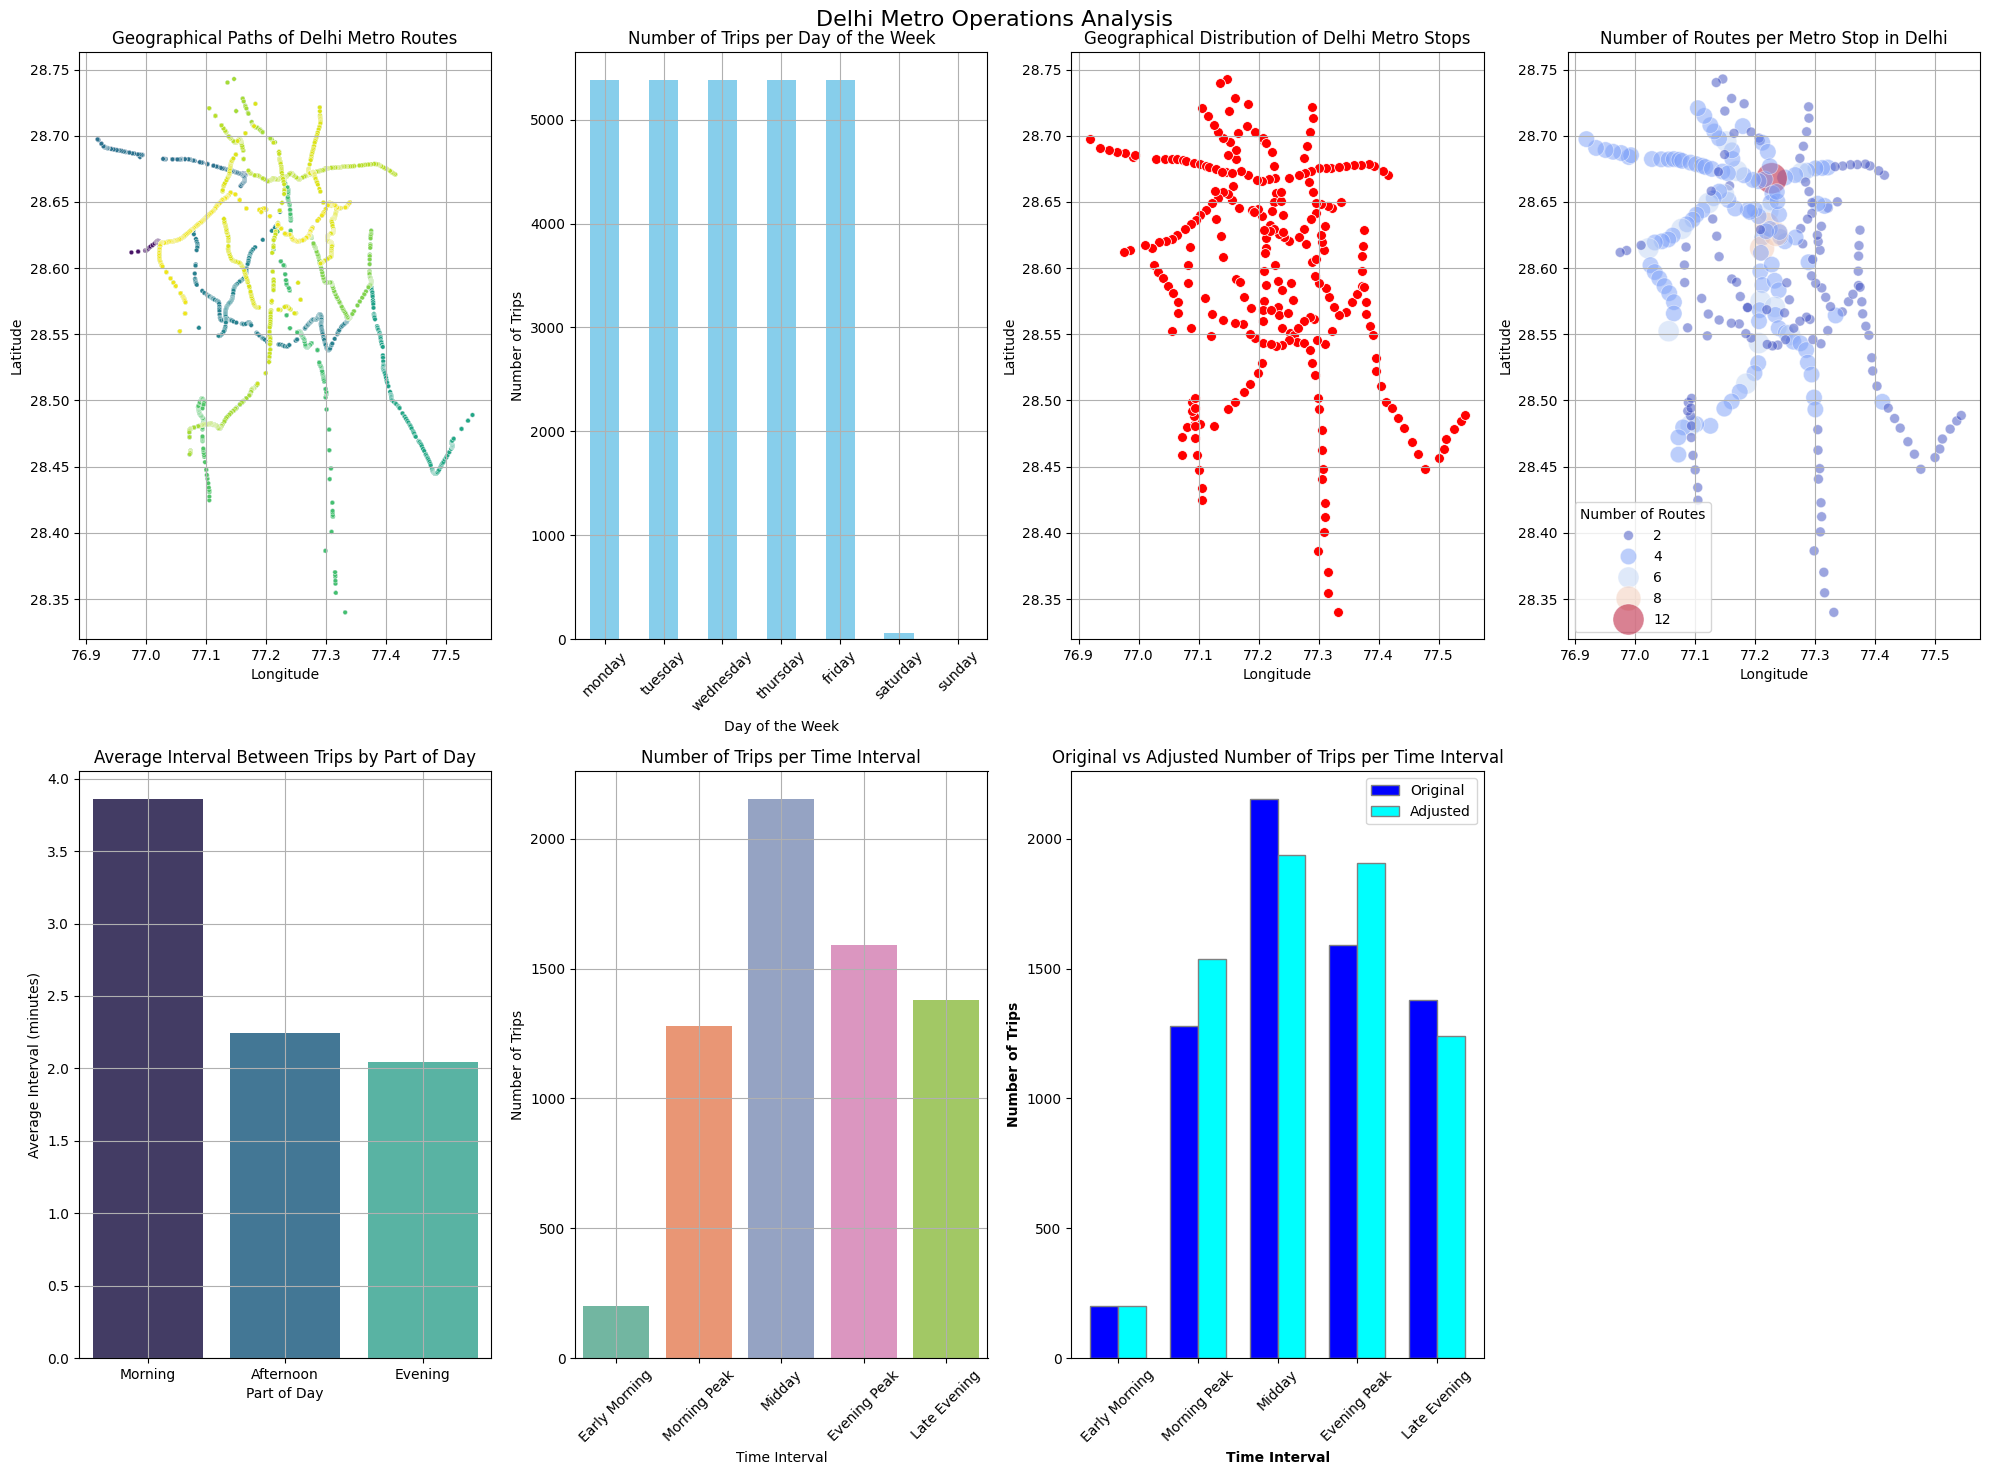

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from google.colab import files  # Import files module for downloading

# Load all the data files
agency = pd.read_csv('agency.txt')
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
shapes = pd.read_csv('shapes.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
trips = pd.read_csv('trips.txt')

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
fig.suptitle('Delhi Metro Operations Analysis', fontsize=16)

# Plot 1: Geographical Paths of Delhi Metro Routes
sns.scatterplot(ax=axes[0, 0], x='shape_pt_lon', y='shape_pt_lat', hue='shape_id', data=shapes, palette='viridis', s=10, legend=None)
axes[0, 0].set_title('Geographical Paths of Delhi Metro Routes')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
axes[0, 0].grid(True)

# Plot 2: Number of Trips per Day of the Week
trips_calendar = pd.merge(trips, calendar, on='service_id', how='left')
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()
trip_counts.plot(ax=axes[0, 1], kind='bar', color='skyblue')
axes[0, 1].set_title('Number of Trips per Day of the Week')
axes[0, 1].set_xlabel('Day of the Week')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True)

# Plot 3: Geographical Distribution of Delhi Metro Stops
sns.scatterplot(ax=axes[0, 2], x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='o')
axes[0, 2].set_title('Geographical Distribution of Delhi Metro Stops')
axes[0, 2].set_xlabel('Longitude')
axes[0, 2].set_ylabel('Latitude')
axes[0, 2].grid(True)

# Plot 4: Number of Routes per Metro Stop in Delhi
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')
sns.scatterplot(ax=axes[0, 3], x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 500), alpha=0.5, palette='coolwarm', data=stop_route_counts)
axes[0, 3].set_title('Number of Routes per Metro Stop in Delhi')
axes[0, 3].set_xlabel('Longitude')
axes[0, 3].set_ylabel('Latitude')
axes[0, 3].legend(title='Number of Routes')
axes[0, 3].grid(True)

# Plot 5: Average Interval Between Trips by Part of Day
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()
sns.barplot(ax=axes[1, 0], x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')
axes[1, 0].set_title('Average Interval Between Trips by Part of Day')
axes[1, 0].set_xlabel('Part of Day')
axes[1, 0].set_ylabel('Average Interval (minutes)')
axes[1, 0].grid(True)

# Plot 6: Number of Trips per Time Interval
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(
    lambda x: 'Early Morning' if x < dt.time(6, 0) else
              'Morning Peak' if x < dt.time(10, 0) else
              'Midday' if x < dt.time(16, 0) else
              'Evening Peak' if x < dt.time(20, 0) else 'Late Evening'
)
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')
sns.barplot(ax=axes[1, 1], x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')
axes[1, 1].set_title('Number of Trips per Time Interval')
axes[1, 1].set_xlabel('Time Interval')
axes[1, 1].set_ylabel('Number of Trips')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True)

# Plot 7: Original vs Adjusted Number of Trips per Time Interval
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]
axes[1, 2].bar(r1, adjusted_trips_per_interval['number_of_trips'], color='blue', width=bar_width, edgecolor='grey', label='Original')
axes[1, 2].bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='cyan', width=bar_width, edgecolor='grey', label='Adjusted')
axes[1, 2].set_xlabel('Time Interval', fontweight='bold')
axes[1, 2].set_ylabel('Number of Trips', fontweight='bold')
axes[1, 2].set_xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))])
axes[1, 2].set_xticklabels(adjusted_trips_per_interval['time_interval'], rotation=45)
axes[1, 2].set_title('Original vs Adjusted Number of Trips per Time Interval')
axes[1, 2].legend()

# Empty the last subplot
axes[1, 3].axis('off')

plt.tight_layout()

# Save the figure
plt.savefig('delhi_metro_analysis.png', dpi=300, bbox_inches='tight')

# Download the figure
files.download('delhi_metro_analysis.png')



In [3]:
# Save the figure
plt.savefig('delhi_metro_analysis.png', dpi=300, bbox_inches='tight')

# Download the figure
files.download('delhi_metro_analysis.png')

NameError: name 'files' is not defined

<Figure size 640x480 with 0 Axes>